# Analyzing Sentiment Trends with Twitter Data

In this notebook, I'm going to match up the tweets to an assigned sentiment, clean up the text data for modeling, and then run a cluster analysis. 

In [1]:
import pandas as pd
from textblob import TextBlob
pd.set_option('display.max_colwidth', -1)
import re
import nltk
import string
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/twint_scraped_clean.csv',  usecols=['date', 'tweet', 'geo'])

In [56]:
#remove data from 12.31 that pulled in
df = df[df['date'] >= '2021-01-01'] 

I've read in the cleaned up data pulled with Twint. Now I'm going to use regex to remove a lot of the stuff in the tweets that I don't want to factor into my analysis, such as links, symbols, and @handles. 

## Cleaning Text with Regex

In [4]:
#creating a new clean column to remove URLs and @ mentions
df['clean_text'] = df['tweet']

#removing links
df['clean_text'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]
df['clean_text'] = [re.sub(r'(https://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]

#removing handles
df['clean_text'] = [re.sub(r'@[^\s]+', '', tweet) for tweet in df['clean_text']]

#removing hashtag symbols but keeping the words
df['clean_text'] = [re.sub(r"#", " ", tweet) for tweet in df['clean_text']]

#twint is pulling in this weird character for apostrophes so I'm replacing it
df['clean_text'] = [re.sub(r"â€™", "'", tweet) for tweet in df['clean_text']]


Much better, I can now focus on the content of the text.

In [5]:
df.head()

,date,tweet,geo,clean_text
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can't be stopped."
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things"
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn't pretend adverse effects don't exist."


## Assinging a Sentiment with Textblob

I'm using the Textblob library which can run a polarity score to analyze the text content to determine how negative or positive it is on a scale. While this capability isn't perfect, it can do a great job of assigning sentiment across large datasets quickly.

After creating a function to score the text, I am adding a column to display the score and another column to classify that score based on Textblob's guidelines.

In [6]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [7]:
# new column to display scores
df['tb_polarity'] = df['clean_text'].apply(get_polarity)

In [8]:
# new column to label sentiment based on score
df['tb_sentiment'] = ''
df.loc[df.tb_polarity > 0, 'tb_sentiment'] = 'positive'
df.loc[df.tb_polarity == 0, 'tb_sentiment'] = 'neutral'
df.loc[df.tb_polarity < 0, 'tb_sentiment'] = 'negative'

In [9]:
df.head()

,date,tweet,geo,clean_text,tb_polarity,tb_sentiment
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can't be stopped.",0.175000,positive
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",0.583333,positive
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian,0.000000,neutral
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine,0.000000,neutral
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn't pretend adverse effects don't exist.",0.053333,positive


## Text Exploration

Now that all my data is labeled, I'm going to look into some trends. 

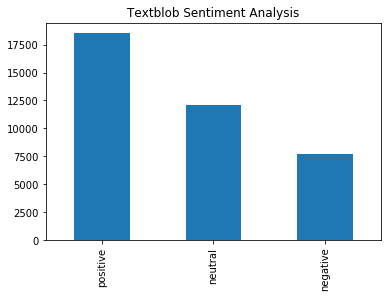

In [10]:
df.tb_sentiment.value_counts().plot(kind='bar',title="Textblob Sentiment Analysis")

Overall, sentiment is mostly positive! One caveat is that Textblob is not necessarily 100% accurate, and many times interpretation can be subjective, especially when the tweet itself is negative but the overall opinion toward vaccines is conveyed as positive. 

To look deeper into positive vs negative, I'm going to show the most frequent words and visualize with a word cloud.

In [11]:
negatives = df[df['tb_sentiment'] == 'negative']
positives = df[df['tb_sentiment'] == 'positive']

In [12]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``']
stopwords_list += punct_list

In [13]:
def tokenize(tweet):
    tokens = nltk.word_tokenize(tweet)
    words_lower = [word.lower() for word in tokens]
    words_stopped = [word for word in words_lower if word not in stopwords_list]
    return words_stopped

In [14]:
processed_data_positive = list(map(tokenize, positives['clean_text']))

processed_data_positive[0]

['definitely',
 'required',
 'every',
 'public',
 'location',
 'library',
 'dmv',
 'etc',
 'also',
 'private',
 'locations',
 'grocery',
 'stores',
 'etc',
 'countries',
 'suffering',
 'lol',
 'us',
 'japan',
 'still',
 'state',
 'emergency',
 'canada',
 'barely',
 'vaccines',
 'virus',
 'ca',
 "n't",
 'stopped']

In [15]:
processed_data_negative = list(map(tokenize, negatives['clean_text']))

processed_data_negative[0]

['hit',
 'today',
 'talmbout',
 'need',
 'sit',
 'talk',
 'heart',
 'dropped',
 "'m",
 'like',
 'granny',
 'say',
 'vaccine',
 'gon',
 'na',
 'get',
 'ðÿ˜',
 '’']

In [16]:
pos_tweet_concat = []
for tweet in processed_data_positive:
    pos_tweet_concat += tweet
    
pos_tweet_freqdist = FreqDist(pos_tweet_concat)
pos_tweet_freqdist.most_common(2000)

[('vaccine', 16249),
 ("'s", 4576),
 ('get', 4332),
 ('vaccines', 4042),
 ("n't", 3947),
 ('covid', 2955),
 ('people', 2605),
 ('first', 2399),
 ('got', 2231),
 ('amp', 2230),
 ("'m", 1898),
 ('getting', 1579),
 ('new', 1524),
 ('dose', 1503),
 ('like', 1409),
 ('one', 1335),
 ('today', 1267),
 ('vaccinated', 1240),
 ('’', 1192),
 ('covid-19', 1175),
 ('shot', 1156),
 ('ðÿ', 1090),
 ('good', 1084),
 ("'re", 994),
 ('covid19', 963),
 ('us', 953),
 ('know', 942),
 ('would', 930),
 ('need', 907),
 ('still', 892),
 ('many', 892),
 ('take', 844),
 ('right', 772),
 ('time', 771),
 ('pfizer', 770),
 ('day', 757),
 ('available', 743),
 ('second', 734),
 ('make', 724),
 ('also', 719),
 ('even', 717),
 ('really', 707),
 ("'ve", 705),
 ('moderna', 702),
 ('go', 699),
 ('appointment', 672),
 ('see', 663),
 ('going', 661),
 ('everyone', 658),
 ('”', 648),
 ('better', 645),
 ('much', 632),
 ('work', 628),
 ('ca', 625),
 ('great', 624),
 ('back', 622),
 ('think', 621),
 ('year', 616),
 ('want', 608),

In [17]:
neg_tweet_concat = []
for tweet in processed_data_negative:
    neg_tweet_concat += tweet
    
neg_tweet_freqdist = FreqDist(neg_tweet_concat)
neg_tweet_freqdist.most_common(2000)

[('vaccine', 6739),
 ("n't", 2285),
 ("'s", 2052),
 ('get', 1742),
 ('vaccines', 1637),
 ('people', 1303),
 ('covid', 1210),
 ("'m", 913),
 ('got', 855),
 ('like', 787),
 ('amp', 761),
 ('getting', 710),
 ('one', 551),
 ("'re", 464),
 ('take', 457),
 ('vaccinated', 434),
 ('would', 434),
 ('still', 428),
 ('us', 411),
 ('know', 368),
 ('go', 365),
 ('even', 351),
 ('going', 350),
 ('dose', 346),
 ('bad', 346),
 ('want', 338),
 ('shot', 335),
 ('ca', 334),
 ('need', 333),
 ('second', 331),
 ('shit', 326),
 ('covid-19', 318),
 ("'ve", 310),
 ('today', 303),
 ('think', 301),
 ('time', 300),
 ('also', 283),
 ('day', 278),
 ('sick', 275),
 ('trump', 273),
 ('’', 270),
 ('long', 260),
 ('ðÿ', 259),
 ('new', 257),
 ('work', 254),
 ('make', 250),
 ('really', 245),
 ('first', 245),
 ('covid19', 245),
 ('fucking', 242),
 ('virus', 237),
 ('could', 234),
 ('year', 232),
 ('least', 229),
 ('2', 229),
 ('pfizer', 222),
 ('appointment', 222),
 ('feel', 221),
 ('rollout', 220),
 ('black', 219),
 ('si

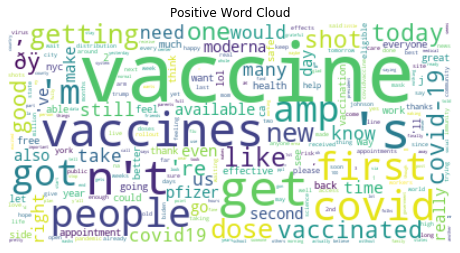

In [18]:
p_wc = WordCloud(background_color="white", max_words=2000)
p_wc.generate_from_frequencies(pos_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(p_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Positive Word Cloud')
plt.show()


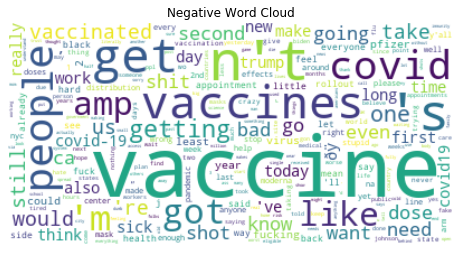

In [19]:
n_wc = WordCloud(background_color="white", max_words=2000)
n_wc.generate_from_frequencies(neg_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(n_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Negative Word Cloud')
plt.show()

WC Analysis


Next, I want to create a dataframe that shows how sentiment trends over time, which I'll use to correlate with the vaccination rate data.

In [20]:
sent_over_time = df[['date', 'tb_polarity']].sort_values(by ='date')
sent_over_time['date'] =pd.to_datetime(sent_over_time['date'])
sent_over_time = sent_over_time.groupby('date').mean()

Text(0.5, 1.0, 'Polarity Score Over Time')

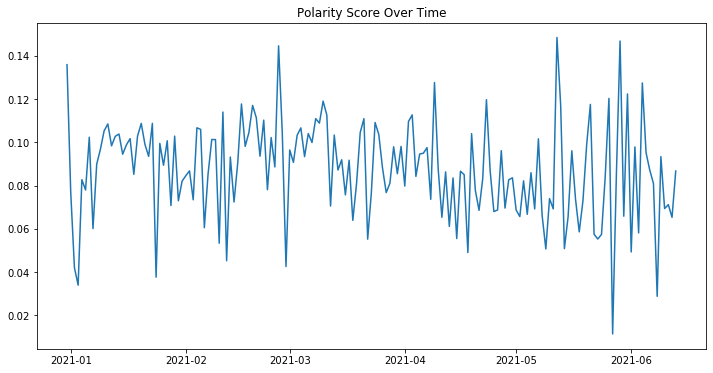

In [21]:
fig = plt.figure(figsize=(12, 6))
plt.plot(sent_over_time)
plt.title("Polarity Score Over Time")

Overall, the trend looks pretty random. Let's take a closer look at different locations. 

In [59]:
def sent_by_location(df, location):
    location_df = df[df['geo'] == location]
    return location_df[['date', 'tb_polarity']].sort_values(by ='date').groupby('date').mean()

In [60]:
hou_sent = sent_by_location(df, 'houston')
chi_sent = sent_by_location(df, 'chicago')
nyc_sent = sent_by_location(df, 'nyc')
la_sent = sent_by_location(df, 'la')

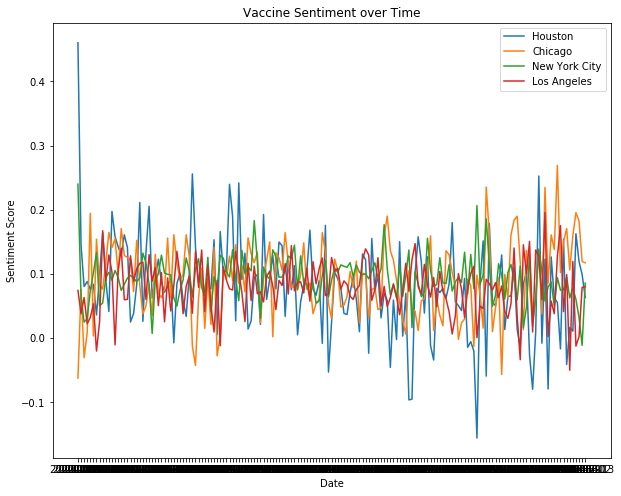

In [24]:
fig = plt.figure(figsize=(10, 8))
plt.plot(hou_sent, label='Houston')  # Plot some data on the axes.
plt.plot(chi_sent, label='Chicago')  # Plot more data on the axes...
plt.plot(nyc_sent, label='New York City')
plt.plot(la_sent, label='Los Angeles')
plt.xlabel('Date')  # Add an x-label to the axes.
plt.ylabel('Sentiment Score')  # Add a y-label to the axes.
plt.title("Vaccine Sentiment over Time")  # Add a title to the axes.
plt.legend()  # Add a legend.

In [61]:
hou_sent.to_csv('data/houston_sentiment.csv')
chi_sent.to_csv('data/chicago_sentiment.csv')
nyc_sent.to_csv('data/nyc_sentiment.csv')
la_sent.to_csv('data/la_sentiment.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/houston_sentiment.csv'

## Cluster Analysis

https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [63]:
negatives['clean_text']

5         She hit me today talmbout we need to sit down and talk, my heart dropped I'm like about what granny? She say about this vaccine and when you gonna get it ðŸ˜’                                                                                                                               
11       â€œCarnival sets Mardi Gras, other Florida cruise ship return sail dates with vaccine requirementâ€� from  for                                                                                                                                                                                
22         Similar to what we saw with B.1.1.7 - we may see localized outbreaks in areas of low seroprevalence, but the vaccine will provide a backstop. Those who were wrong about B.1.1.7, will be wrong about the Delta variant as well.                                                            
27        Yes, to protect others who are vulnerable as well as children under the age of 12 who cannot get a vac

In [32]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data_negative = negatives.clean_text.values.tolist()
words_negative = list(sent_to_words(data))


In [33]:
words_negative

[['it',
  'was',
  'definitely',
  'required',
  'in',
  'every',
  'public',
  'location',
  'library',
  'dmv',
  'etc',
  'also',
  'in',
  'most',
  'private',
  'locations',
  'grocery',
  'stores',
  'etc',
  'other',
  'countries',
  'are',
  'suffering',
  'too',
  'lol',
  'not',
  'just',
  'us',
  'japan',
  'is',
  'still',
  'in',
  'state',
  'of',
  'emergency',
  'canada',
  'has',
  'barely',
  'any',
  'vaccines',
  'the',
  'virus',
  'can',
  'be',
  'stopped'],
 ['went',
  'to',
  'the',
  'park',
  'where',
  'guitar',
  'bass',
  'drum',
  'jazz',
  'trio',
  'plays',
  'every',
  'sunday',
  'and',
  'got',
  'to',
  'see',
  'more',
  'friends',
  'including',
  'some',
  'two',
  'days',
  'in',
  'row',
  'vaccine',
  'and',
  'summer',
  'are',
  'some',
  'pretty',
  'wonderful',
  'things'],
 ['covid',
  'cases',
  'fall',
  'across',
  'us',
  'but',
  'experts',
  'warn',
  'of',
  'dangers',
  'of',
  'vaccine',
  'hesitancy',
  'the',
  'guardian'],
 [

In [34]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(words_negative)
# Create Corpus
texts = words_negative
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [35]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"vaccine" + 0.037*"the" + 0.030*"for" + 0.028*"ðy" + 0.026*"covid" + '
  '0.018*"my" + 0.014*"to" + 0.012*"and" + 0.011*"in" + 0.010*"on"'),
 (1,
  '0.044*"the" + 0.039*"vaccine" + 0.024*"to" + 0.015*"for" + 0.013*"in" + '
  '0.011*"covid" + 0.011*"they" + 0.011*"as" + 0.010*"vaccines" + 0.009*"on"'),
 (2,
  '0.040*"to" + 0.030*"vaccine" + 0.030*"for" + 0.013*"vaccines" + 0.013*"the" '
  '+ 0.011*"get" + 0.011*"in" + 0.011*"is" + 0.011*"of" + 0.010*"and"'),
 (3,
  '0.060*"the" + 0.043*"vaccine" + 0.032*"to" + 0.024*"of" + 0.023*"and" + '
  '0.023*"in" + 0.014*"covid" + 0.014*"get" + 0.013*"for" + 0.009*"is"'),
 (4,
  '0.053*"the" + 0.038*"vaccine" + 0.023*"for" + 0.021*"to" + 0.017*"and" + '
  '0.016*"of" + 0.013*"in" + 0.012*"covid" + 0.010*"is" + 0.010*"my"'),
 (5,
  '0.050*"the" + 0.035*"to" + 0.034*"vaccine" + 0.029*"you" + 0.024*"and" + '
  '0.018*"is" + 0.017*"of" + 0.016*"it" + 0.013*"that" + 0.012*"get"'),
 (6,
  '0.041*"the" + 0.032*"vaccine" + 0.024*"to" + 0.024

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()

In [49]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [50]:
with open('LDAvis_prepared.pickle', 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open('LDAvis_prepared.pickle', 'rb') as f:
    LDAvis_prepared = pickle.load(f)

    # pyLDAvis.save_html(LDAvis_prepared)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.045887  0.030801  1       1        23.378491
6      0.008185  0.045154  2       1        15.933455
3     -0.004218  0.019618  3       1        14.730209
8      0.069370  0.017305  4       1        12.018420
7     -0.007924  0.018373  5       1        8.211847 
9     -0.098499  0.030799  6       1        7.980643 
4     -0.000642 -0.007187  7       1        5.526303 
2      0.042616 -0.061526  8       1        4.657208 
0     -0.066681 -0.050991  9       1        4.243024 
1      0.011905 -0.042347  10      1        3.320401 , topic_info=        Term          Freq         Total Category  logprob  loglift
139  ðy       10855.000000  10855.000000  Default  30.0000  30.0000
64   vaccine  34532.000000  34532.000000  Default  29.0000  29.0000
36   the      41036.000000  41036.000000  Default  28.0000  28.0000
97   for      11465.000000  11465.000000  Default  27.0000  27.0000
128  my       10147.000000  10147.000000  Default  26.0000  26.0000
..   ..                ...           ...      ...      ...      ...
128  my       178.497450    10147.915584  Topic10 -5.1332  -0.6354 
4    be       141.183065    5459.793929   Topic10 -5.3677  -0.2500 
26   of       168.298082    14438.285267  Topic10 -5.1920  -1.0468 
116  with     136.805835    4946.345874   Topic10 -5.3992  -0.1828 
139  ðy       153.736676    10855.553616  Topic10 -5.2825  -0.8521 

[881 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
119    1      0.343423  about
119    2      0.118078  about
119    3      0.241278  about
119    4      0.134296  about
119    5      0.029306  about
...   ..           ...    ...
2200   6      0.244650  œðy  
2200   8      0.007645  œðy  
2200   9      0.412847  œðy  
2200   10     0.003823  œðy  
10015  1      0.972215  ˆa   

[2305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 4, 9, 8, 10, 5, 3, 1, 2])